In [33]:
import numpy as np
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from keras import optimizers
from keras import losses
from keras import metrics
import keras_tuner
import matplotlib.pyplot as plt

---

Завантажемо наш датасет:

In [34]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [35]:
train_images.shape, type(train_images[0]), train_images[0].shape

((60000, 28, 28), numpy.ndarray, (28, 28))

In [36]:
test_images.shape, type(test_images[0]), test_images[0].shape

((10000, 28, 28), numpy.ndarray, (28, 28))

In [37]:
# Перетворюємо дані
train_images = train_images.reshape((-1, 28, 28, 1))
test_images = test_images.reshape((-1, 28, 28, 1))
train_images = train_images / 255.0
test_images = test_images / 255.0

train_labels = to_categorical(train_labels, num_classes=10)
test_labels = to_categorical(test_labels, num_classes=10)

In [38]:
# Перетворення в картинки 32х32 за 3-ма каналами
train_images = tf.convert_to_tensor(train_images)
train_labels = tf.convert_to_tensor(train_labels)
test_images = tf.convert_to_tensor(test_images)
test_labels = tf.convert_to_tensor(test_labels)

train_images = tf.image.grayscale_to_rgb(train_images)
test_images = tf.image.grayscale_to_rgb(test_images)


train_images = tf.image.resize(train_images, [32, 32])
test_images = tf.image.resize(test_images, [32, 32])
train_images.shape,test_images.shape

(TensorShape([60000, 32, 32, 3]), TensorShape([10000, 32, 32, 3]))

In [39]:
# Функція для виведення графіків loss функції та точності на валідаційній вибірці
def plot_history(history):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']

    epochs = range(1, len(history_dict['accuracy']) + 1)

    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.clf()
    val_acc_values = history_dict['val_accuracy']
    plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training acc')
    plt.plot(epochs, history_dict['val_accuracy'], 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

---

Будемо використовувати згорткові шари з VGG16 та додамо свої верхні шари (виділення ознак):

In [40]:
from keras.applications.vgg16 import VGG16

conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))
conv_base.trainable = False

In [41]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [42]:
model = Sequential([
   conv_base,
   Flatten(),
   Dense(256, activation="relu"),
   Dense(128, activation="relu"),
   Dense(10, activation="softmax"),
])

model.build(input_shape=(None, 32, 32, 3))

In [43]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,880,202 (56.76 MB)

 Trainable params: 165,514 (646.54 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [44]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,880,202 (56.76 MB)

 Trainable params: 165,514 (646.54 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [45]:
x_val = train_images[:10000]
partial_x_train = train_images[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

Epoch 1/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.6442 - loss: 1.1463 - val_accuracy: 0.8225 - val_loss: 0.5023
Epoch 2/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8225 - val_loss: 0.5023
Epoch 3/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.8265 - loss: 0.4832 - val_accuracy: 0.8433 - val_loss: 0.4287
Epoch 4/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8433 - val_loss: 0.4287
Epoch 5/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.8496 - loss: 0.4151 - val_accuracy: 0.8519 - val_loss: 0.4063
Epoch 6/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8519 - val_loss: 0.4063
Epoch 7/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.8573 - loss: 0.3906 - val_accuracy: 0.8585 - val_loss: 0.3819
Epoch 8/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.0000e

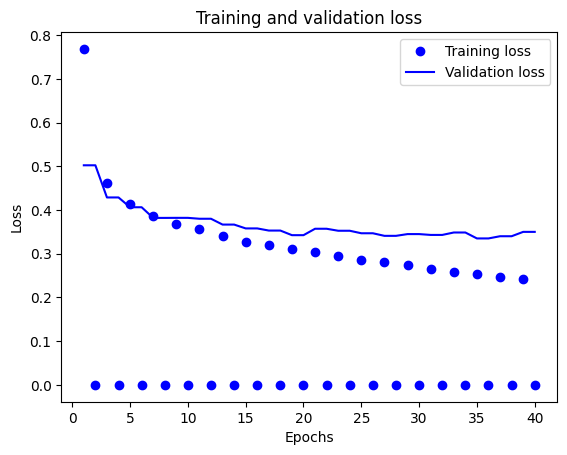

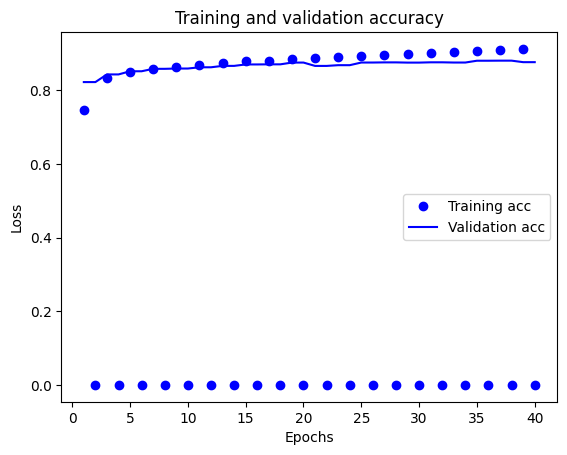

In [46]:
history = model.fit(
    partial_x_train,
    partial_y_train,
    steps_per_epoch=100,
    epochs=40,
    validation_data=(x_val,y_val),
)

plot_history(history)

In [47]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8676 - loss: 0.3706
0.8666999936103821


---

Точність вже непогана, але тепер ми розморозимо згорткові шари і навчимо і їх:

In [52]:
conv_base.trainable = True

Доцільно використати дуже малу швидкість навчання, щоб не зробити занадто великі зміни в шарах:

In [53]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Epoch 1/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.9742 - loss: 0.0832 - val_accuracy: 0.9023 - val_loss: 0.3064
Epoch 2/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9023 - val_loss: 0.3064
Epoch 3/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9762 - loss: 0.0811 - val_accuracy: 0.9022 - val_loss: 0.3099
Epoch 4/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9022 - val_loss: 0.3099
Epoch 5/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.9765 - loss: 0.0775 - val_accuracy: 0.8998 - val_loss: 0.3156
Epoch 6/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8998 - val_loss: 0.3156
Epoch 7/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.9775 - loss: 0.0760 - val_accuracy: 0.8990 - val_loss: 0.3126
Epoch 8/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0000e+

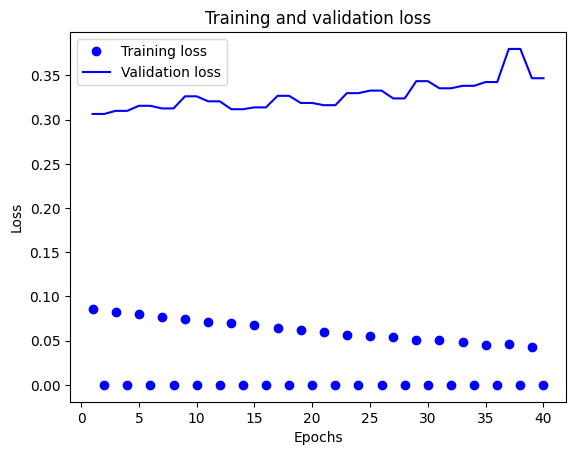

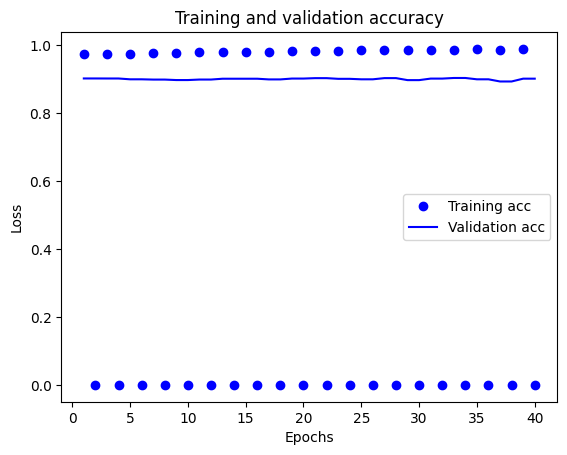

In [56]:
history = model.fit(
    partial_x_train,
    partial_y_train,
    steps_per_epoch=100,
    epochs=40,
    validation_data=(x_val,y_val),
    validation_batch_size = 200
)

plot_history(history)

In [58]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8937 - loss: 0.3597
0.8931000232696533


__Висновок:__ модель працює дійсно з великою точністю. Тим не менш, вона точно не краща за точність в попередньому завданні без використання згорток. Це може бути через те, що VGG16 за вагами imagenet все-таки не зовсім розрахована на піксельні зображення з fashion_mnist. Або ж модель потребує дуже обережного вибору параметрів, щоб отримати кращий результат.